# Table of Contents

# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

# Read In CSV

In [2]:
eth = pd.read_csv('./data/ohlcv_daily.csv')

# Functions

In [3]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name='predictions')
    combined = pd.concat([test['target'], preds], axis=1)
    
    plt.figure(figsize=(12,6))
    
    plt.plot(combined.index, combined['target'], label='Target')
    plt.plot(combined.index, combined['predictions'], label='Predictions')
    plt.legend()

    visualization_folder = 'visualizations'
    os.makedirs(visualization_folder, exist_ok=True)

    save_path = os.path.join(visualization_folder, f"visualization_{len(os.listdir(visualization_folder)) + 1}.png")
    plt.savefig(save_path)
    
    plt.show()
    
    return combined

In [4]:
# 3 years worth of historical data we want to use before we start making predictions and make predictions every 6 months
def backtest(data, model, predictors, start=1095, step=150): 
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

# Train XGBoost Model

## Model w/ No Feature Engineering

In [6]:
predictors = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment']

X = eth[predictors]
y = eth['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

xgb = XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='precision', cv=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

final_xgb_no_fe = XGBClassifier(random_state=42, **best_params)

final_xgb_no_fe.fit(X_train, y_train)

preds = final_xgb_no_fe.predict(X_test)

precision = precision_score(y_test, preds)
print("Precision:", precision)

Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
Precision: 0.5740740740740741


## Model w/ Feature Engineering

In [12]:
new_predictors = ['close', 'sentiment', 'negative_sentiment', 'close_ratio_2', 'trend_2', 'edit_2', 'close_ratio_7', 'trend_7', 'edit_7', 'close_ratio_60', 'trend_60', 'edit_60', 'close_ratio_365', 'trend_365', 'edit_365']

X = eth[new_predictors]
y = eth['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

xgb = XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='precision', cv=3)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

final_xgb = XGBClassifier(random_state=42, **best_params)

final_xgb.fit(X_train, y_train)

preds = final_xgb.predict(X_test)

precision = precision_score(y_test, preds)
print("Precision:", precision)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1.0}
Precision: 0.5652173913043478


# Evaluate Model

## Backtest XGBoost Model w/ No Feature Engineering

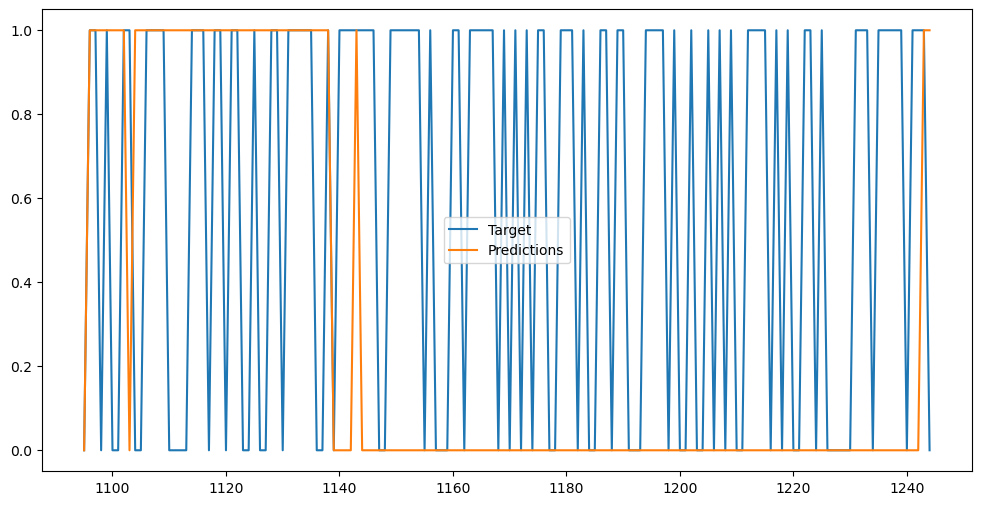

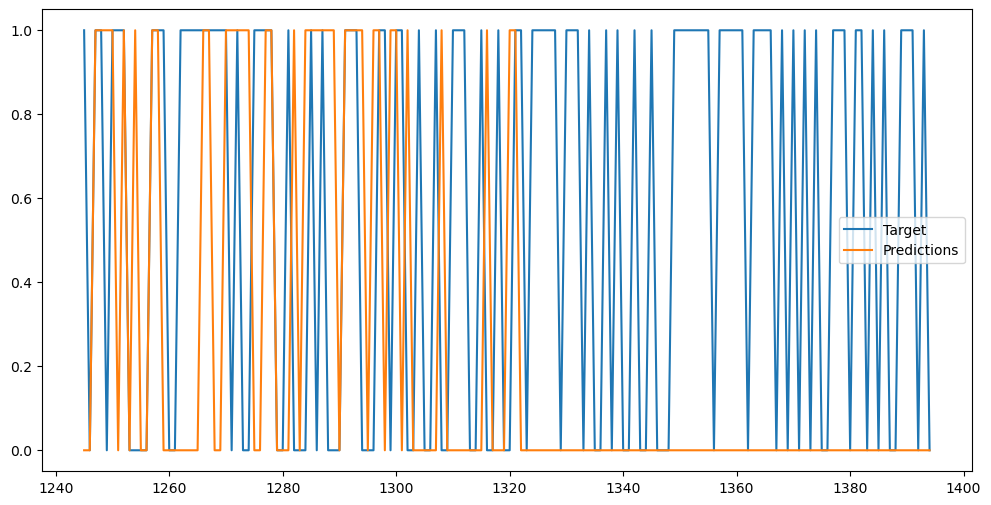

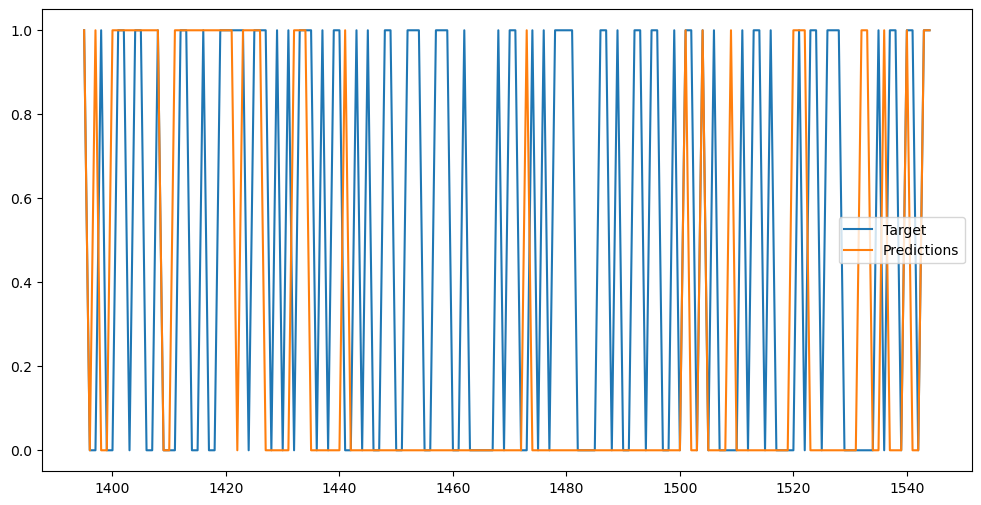

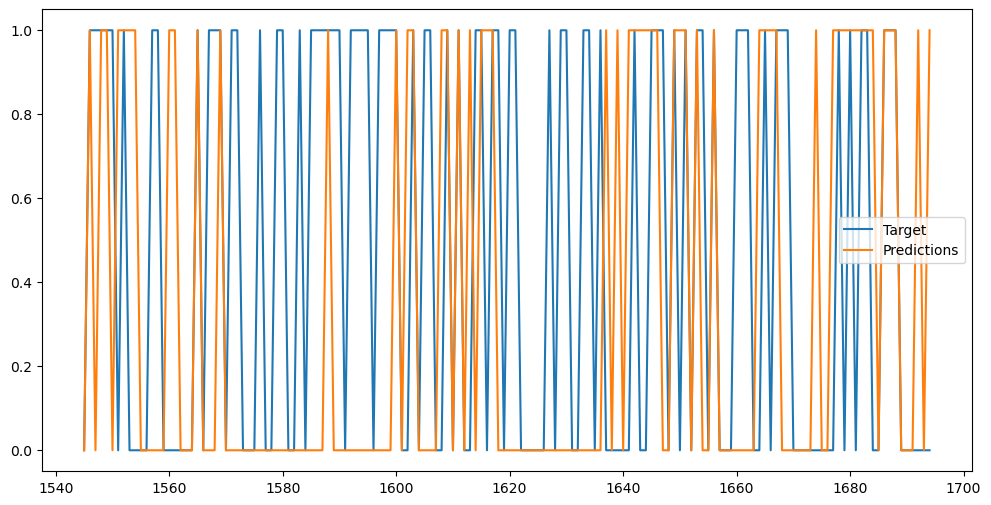

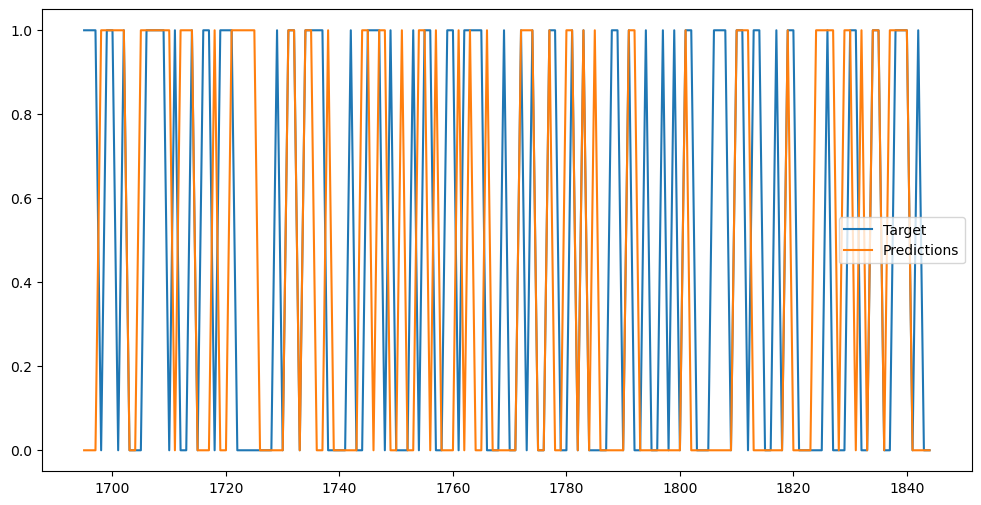

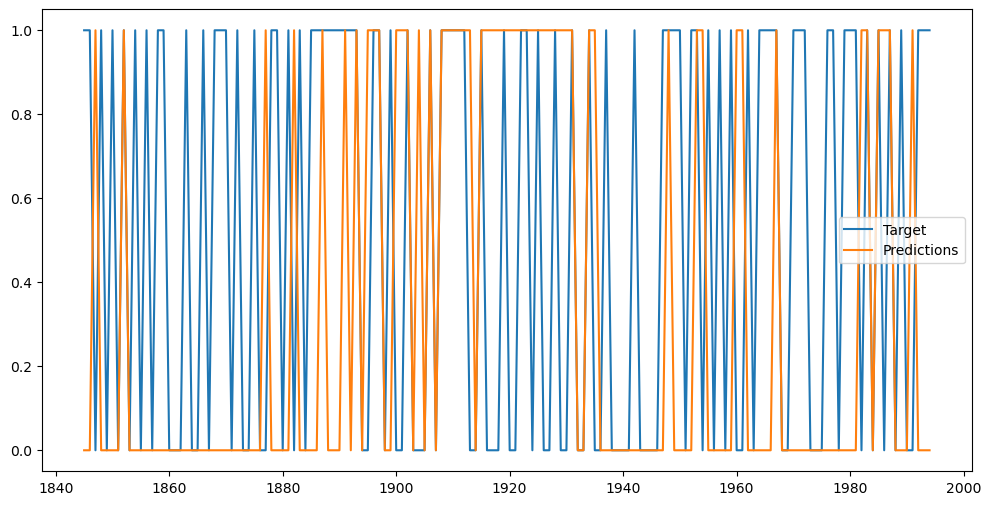

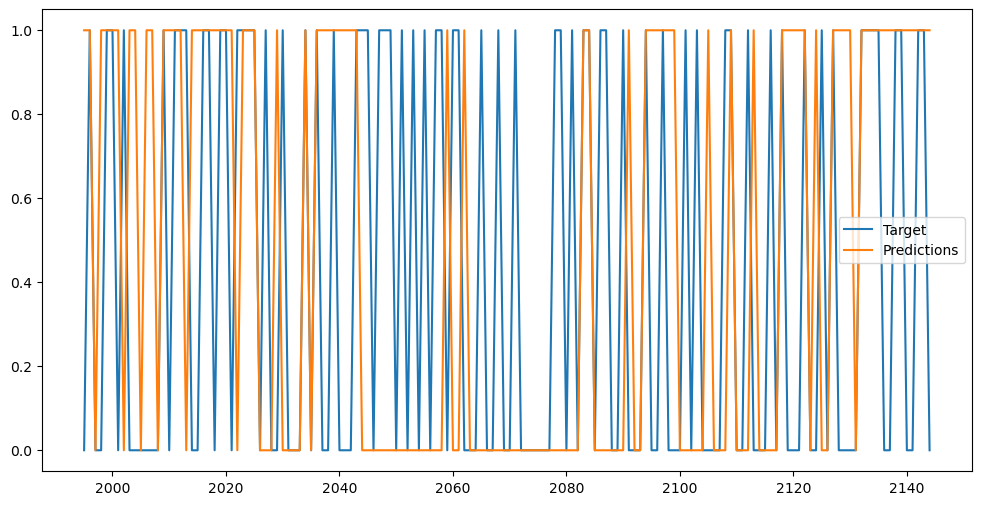

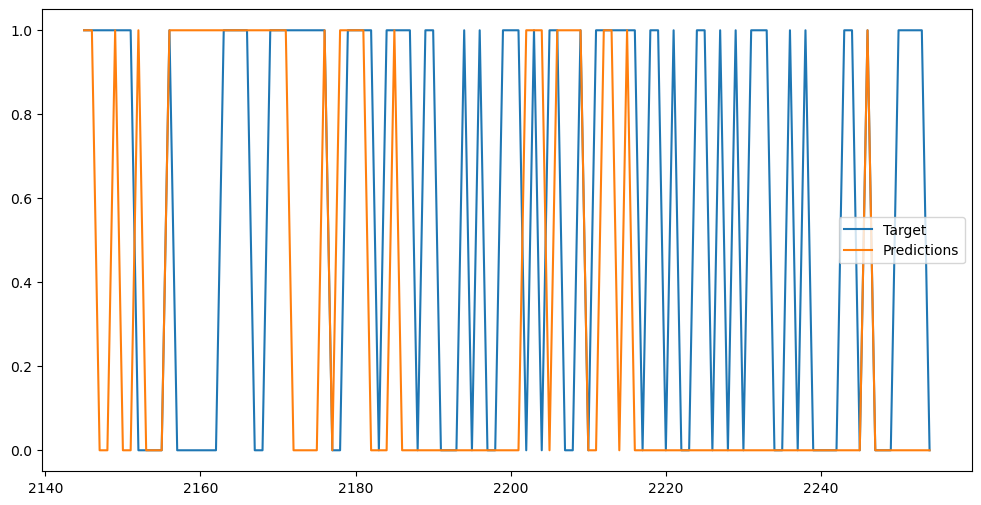

In [8]:
xgb_no_fe_predictions = backtest(eth, final_xgb_no_fe, predictors)

In [9]:
# Baseline
xgb_no_fe_predictions['target'].value_counts() / xgb_no_fe_predictions.shape[0]

1    0.517241
0    0.482759
Name: target, dtype: float64

In [10]:
precision_score(xgb_no_fe_predictions['target'], xgb_no_fe_predictions['predictions'])

0.533498759305211

## Backtest XGBoost Model w/ Feature Engineering

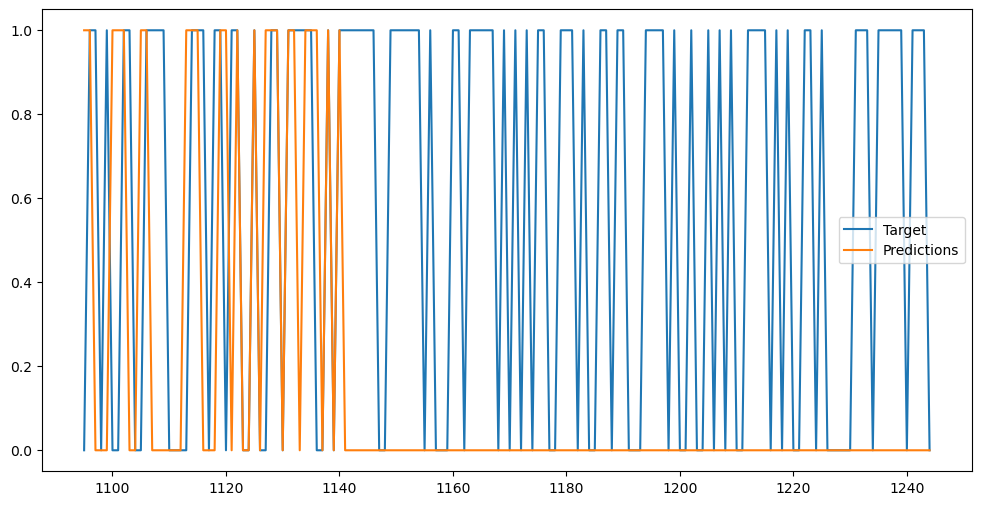

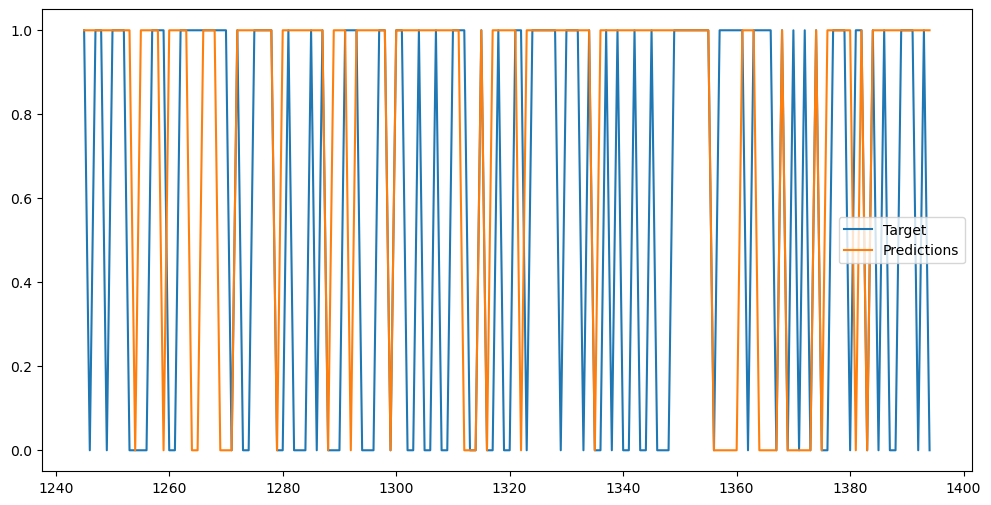

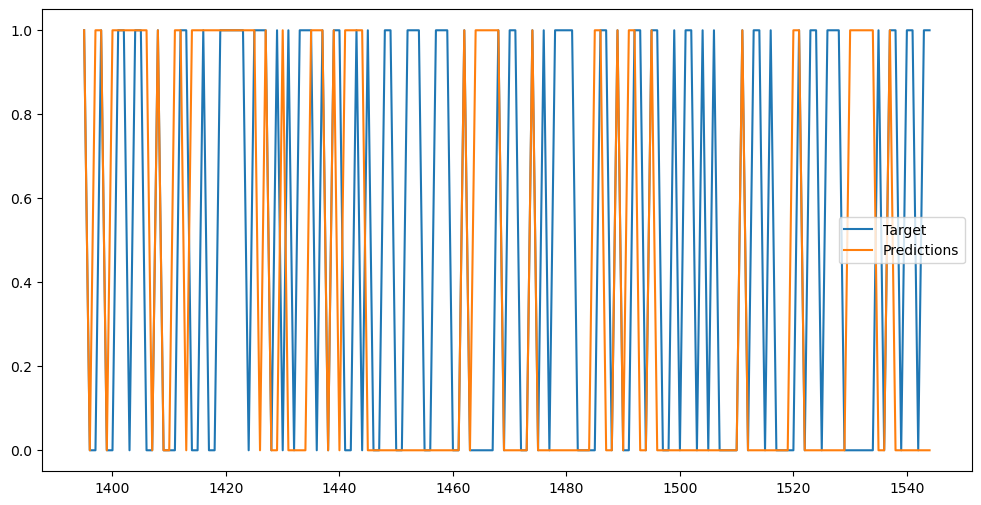

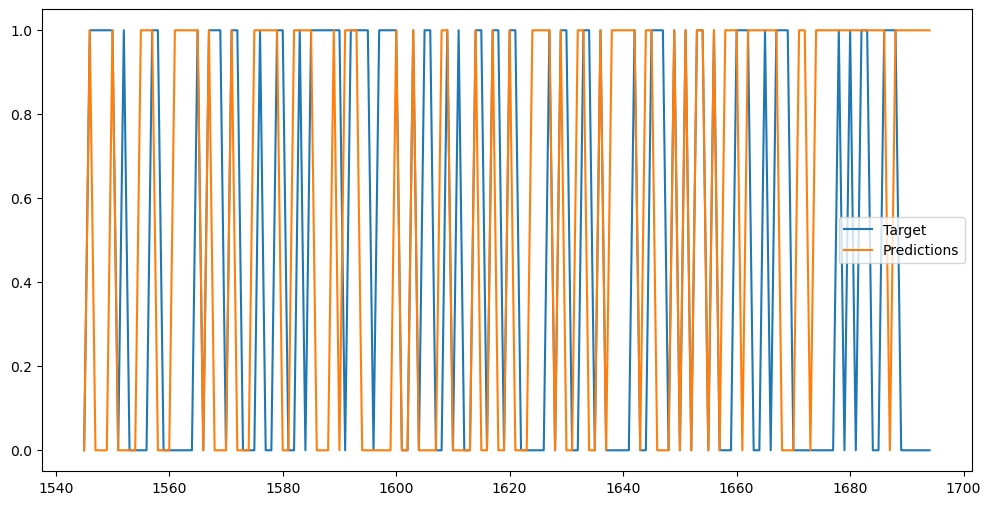

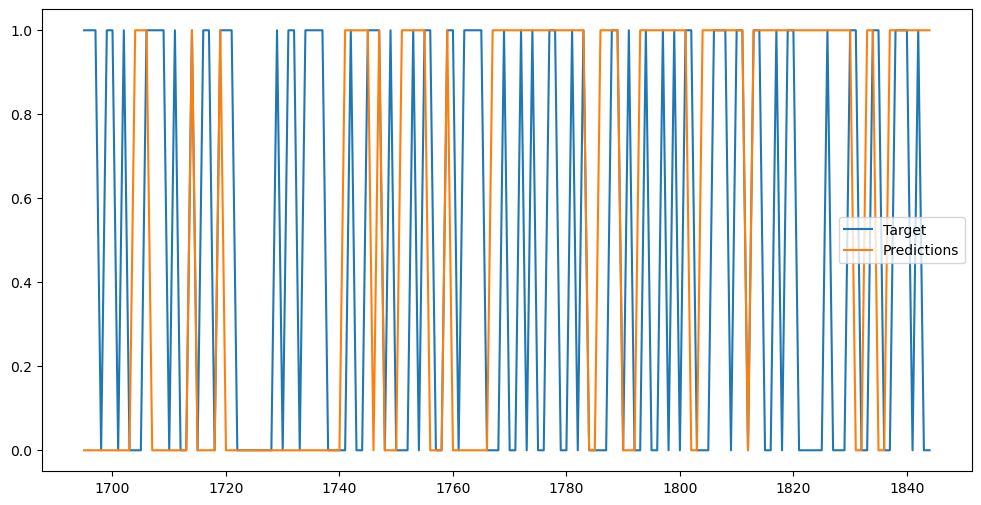

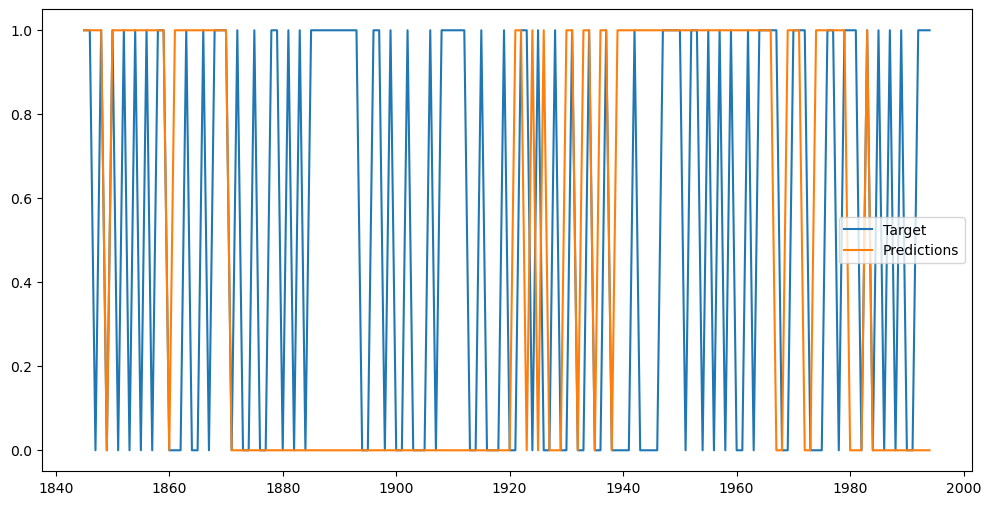

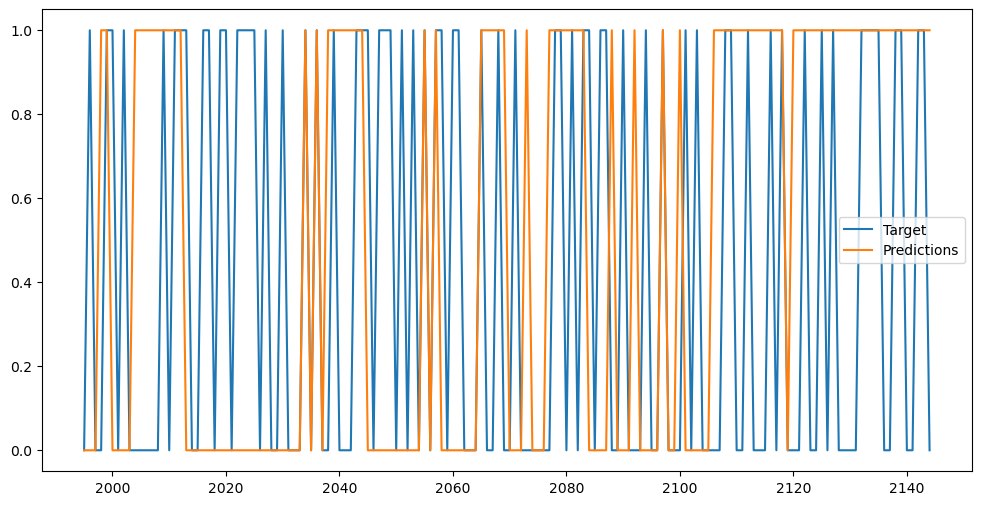

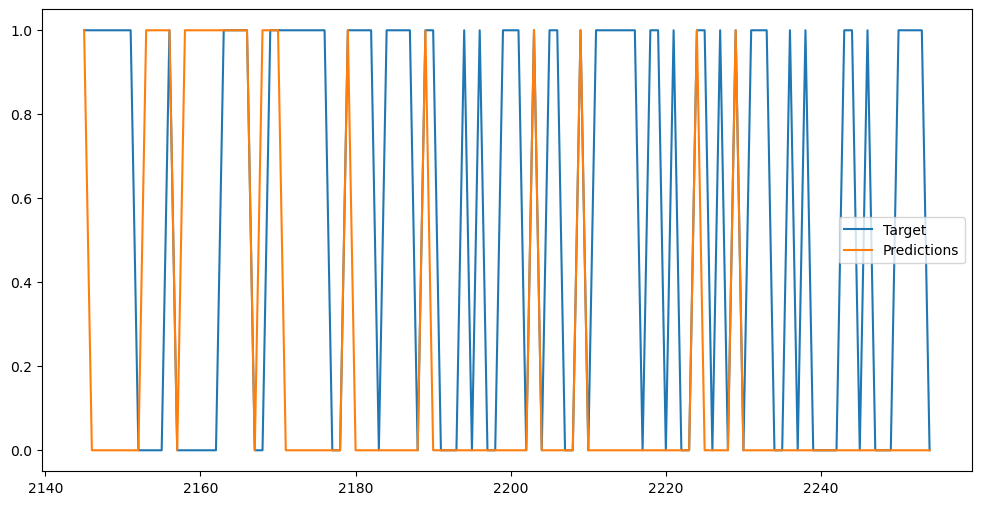

In [13]:
xgb_fe_predictions = backtest(eth, final_xgb, new_predictors)

In [14]:
# Baseline
xgb_fe_predictions['target'].value_counts() / xgb_fe_predictions.shape[0]

1    0.517241
0    0.482759
Name: target, dtype: float64

In [15]:
precision_score(xgb_fe_predictions['target'], xgb_fe_predictions['predictions'])

0.5214953271028038

Model got worst as we added the rolling averages for our backtest but regardless both models still beat baseline